---
## Chapter 4 – The Limits of Classical ML
---

## Global conventions

In [1]:
# --- Global seeds & imports (put once) ---
import os, random, numpy as np, pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"]=str(SEED)

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 130

# helper: consistent chronological split (for ADR/time series)
def chrono_split(X, y, train_frac=0.6, val_frac=0.2):
    n = len(X); n_tr = int(train_frac*n); n_va = int(val_frac*n)
    X_tr, X_va, X_te = X.iloc[:n_tr], X.iloc[n_tr:n_tr+n_va], X.iloc[n_tr+n_va:]
    y_tr, y_va, y_te = y.iloc[:n_tr], y.iloc[n_tr:n_tr+n_va], y.iloc[n_tr+n_va:]
    return X_tr, y_tr, X_va, y_va, X_te, y_te

### Exercise 1 — Two-moons: Poly LR (deg=2/3) vs RBF SVM

PolyLR_deg2   test acc = 0.920
PolyLR_deg3   test acc = 0.970
RBF_SVM       test acc = 0.965


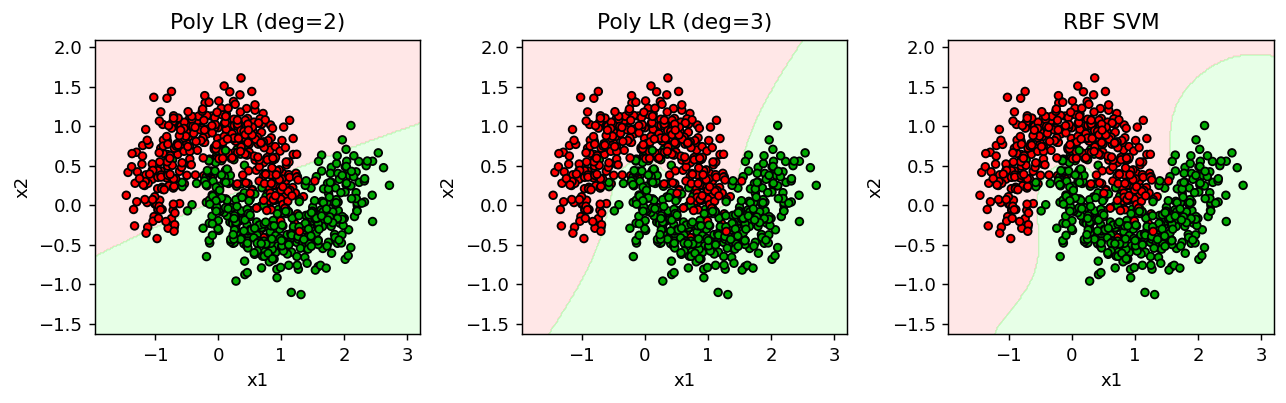

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# --- Data ---
X, y = make_moons(n_samples=1000, noise=0.25, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

# --- Models ---
pipe_deg2 = Pipeline([
    ("sc", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LogisticRegression(max_iter=2000))
])
pipe_deg3 = Pipeline([
    ("sc", StandardScaler()),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("lr", LogisticRegression(max_iter=2000))
])
pipe_rbf = Pipeline([
    ("sc", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# --- Train & Evaluate ---
for name, model in [("PolyLR_deg2", pipe_deg2), ("PolyLR_deg3", pipe_deg3), ("RBF_SVM", pipe_rbf)]:
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:12s}  test acc = {acc:.3f}")

# --- Boundary plot without warnings ---
def plot_boundary(model, X_mat, y_vec, title):
    h = 0.02
    x_min, x_max = X_mat[:,0].min()-0.5, X_mat[:,0].max()+0.5
    y_min, y_max = X_mat[:,1].min()-0.5, X_mat[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]  # numpy grid → no feature-name warnings
    Z = model.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(["#FFBBBB","#BBFFBB"]), alpha=0.35)
    plt.scatter(X_mat[:,0], X_mat[:,1], c=y_vec, s=18, edgecolor="k",
                cmap=ListedColormap(["#FF0000","#00AA00"]))
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")

plt.figure(figsize=(10,3.2))
plt.subplot(1,3,1); plot_boundary(pipe_deg2, X_train, y_train, "Poly LR (deg=2)")
plt.subplot(1,3,2); plot_boundary(pipe_deg3, X_train, y_train, "Poly LR (deg=3)")
plt.subplot(1,3,3); plot_boundary(pipe_rbf,  X_train, y_train, "RBF SVM")
plt.tight_layout(); plt.show()

### Exercise 2 — Distance Concentration

In [3]:
from sklearn.metrics import pairwise_distances

def distance_concentration(n=1000, dims=(2,4,8,16,32,64,128,256), seed=SEED):
    rng = np.random.default_rng(seed)
    rows = []
    for d in dims:
        X = rng.normal(0, 1, size=(n, d))
        D = pairwise_distances(X, metric="euclidean")
        # ignore self-distances by setting diagonal to +inf for min, 0 for max
        np.fill_diagonal(D, np.inf)
        nearest = D.min(axis=1).mean()
        np.fill_diagonal(D, 0.0)
        farthest = D.max(axis=1).mean()
        contrast = farthest / nearest
        rows.append({"dim": d, "nearest": nearest, "farthest": farthest, "contrast": contrast})
    return pd.DataFrame(rows)

df_dc = distance_concentration()
df_dc

,dim,nearest,farthest,contrast
0,2,0.078972,4.598089,58.224389
1,4,0.473446,5.614423,11.858644
2,8,1.397406,6.759090,4.836883
3,16,2.948452,8.366743,2.837673
4,32,5.247214,10.851402,2.068031
5,64,8.543229,14.217713,1.664208
6,128,13.178656,18.911739,1.435028
7,256,19.866986,25.383512,1.277673


### Exercise 3 — Feature growth with `PolynomialFeatures`

,Degree,Total Features,Feature Growth xBase
0,1,9,1.00
1,2,54,6.00
2,3,219,24.33
3,4,714,79.33
4,5,2001,222.33


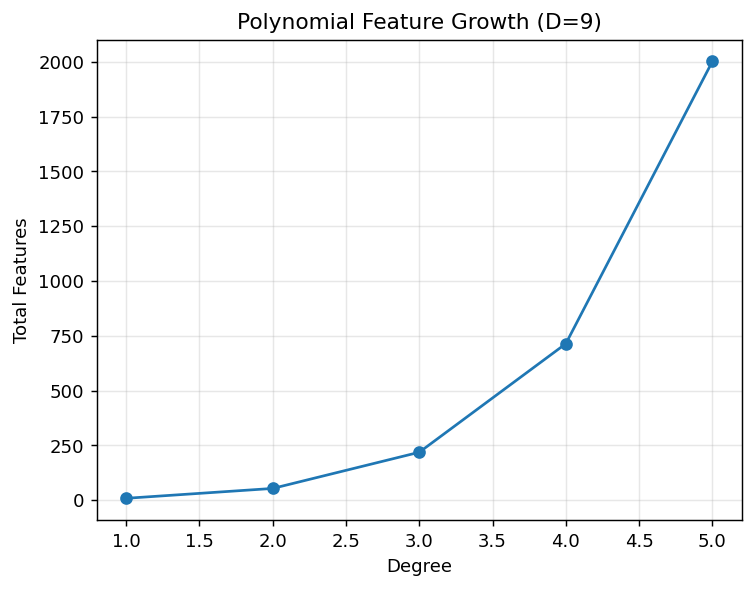

In [4]:
import math

def n_terms_up_to_k(D, k, include_bias=False):
    return sum(math.comb(D + d - 1, d) for d in range(1, k+1)) + (1 if include_bias else 0)

D = 9
rows = [
    {"Degree": k,
     "Total Features": n_terms_up_to_k(D, k, include_bias=False),
     "Feature Growth xBase": round(n_terms_up_to_k(D, k, False)/D, 2)}
    for k in range(1, 6)
]
df = pd.DataFrame(rows)

# --- Show table ---
display(df)

# --- Simple plot ---
plt.plot(df["Degree"], df["Total Features"], marker="o")
plt.title(f"Polynomial Feature Growth (D={D})")
plt.xlabel("Degree")
plt.ylabel("Total Features")
plt.grid(True, alpha=0.3)
plt.show()

### Exercise 4 — Learning curves (Logistic vs RBF SVM)

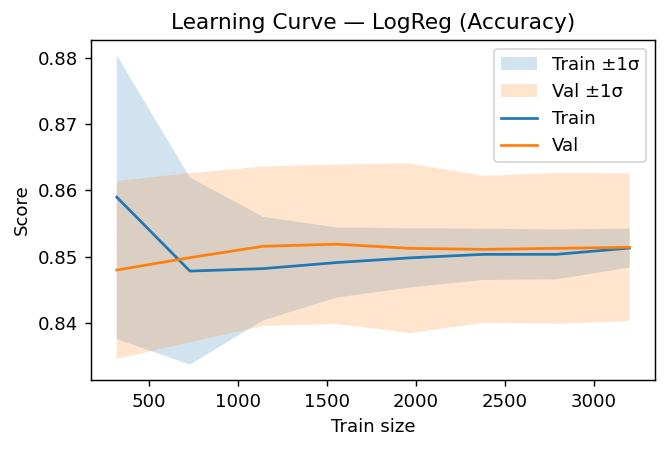

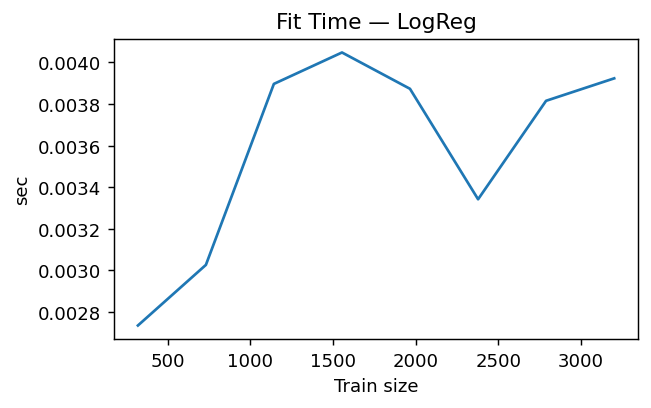

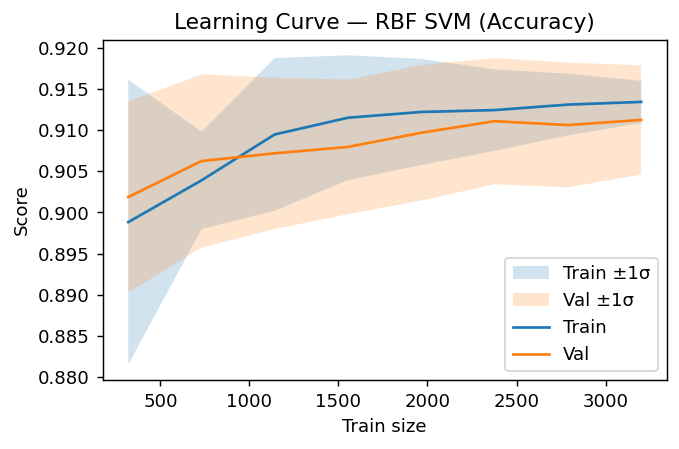

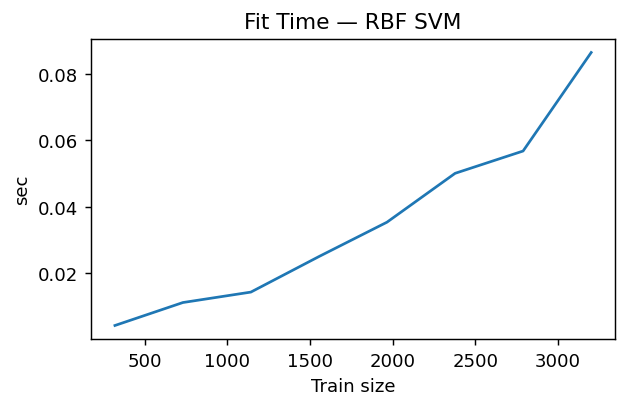

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.pipeline import make_pipeline


# choose a classification dataset for this demo:
from sklearn.datasets import make_moons
X_cls, y_cls = make_moons(n_samples=4000, noise=0.30, random_state=SEED)

cv = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=SEED)
train_sizes = np.linspace(0.1, 1.0, 8)

def lc(estimator):
    ts, tr, va, fit_t, _ = learning_curve(estimator, X_cls, y_cls,
                                          cv=cv, train_sizes=train_sizes,
                                          scoring="accuracy", n_jobs=-1,
                                          return_times=True, shuffle=True)
    return ts, tr.mean(1), tr.std(1), va.mean(1), va.std(1), fit_t.mean(1)

pipe_lr  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_svm = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0, gamma="scale"))

for name, est in [("LogReg", pipe_lr), ("RBF SVM", pipe_svm)]:
    ts, tr_m, tr_s, va_m, va_s, t_fit = lc(est)
    plt.figure(figsize=(5.6,3.4))
    plt.fill_between(ts, tr_m-tr_s, tr_m+tr_s, alpha=0.2, label="Train ±1σ")
    plt.fill_between(ts, va_m-va_s, va_m+va_s, alpha=0.2, label="Val ±1σ")
    plt.plot(ts, tr_m, label="Train"); plt.plot(ts, va_m, label="Val")
    plt.title(f"Learning Curve — {name} (Accuracy)"); plt.xlabel("Train size"); plt.ylabel("Score"); plt.legend(); plt.show()

    plt.figure(figsize=(5.2,3))
    plt.plot(ts, t_fit)
    plt.title(f"Fit Time — {name}"); plt.xlabel("Train size"); plt.ylabel("sec"); plt.show()

### Challenge 1 — Feature brittleness (ADR)

,Set,Accuracy,AUC,F1
0,Train (A),0.850,0.941138,0.843206
1,Shifted Test (B),0.845,0.935294,0.850242


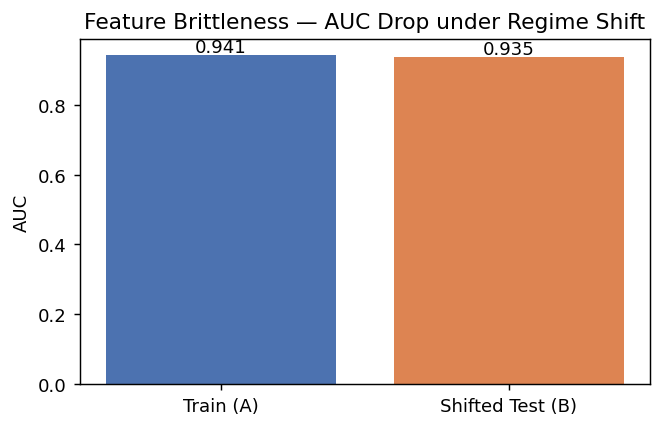

AUC Drop under shift: 0.006


In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# --- Ensure Pandas types for chronological slicing ---
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)
if not isinstance(y, (pd.Series, pd.DataFrame)):
    y = pd.Series(y)

# --- Chronological split ---
X_tr, y_tr, X_va, y_va, X_te, y_te = chrono_split(X, y, 0.6, 0.2)

# --- Fit Logistic Regression pipeline ---
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X_tr, y_tr)

# --- Predictions & Probabilities ---
proba_tr = pipe.predict_proba(X_tr)[:, 1]
proba_te = pipe.predict_proba(X_te)[:, 1]

# --- Evaluation ---
res = pd.DataFrame({
    "Set": ["Train (A)", "Shifted Test (B)"],
    "Accuracy": [accuracy_score(y_tr, (proba_tr >= 0.5).astype(int)),
                 accuracy_score(y_te, (proba_te >= 0.5).astype(int))],
    "AUC": [roc_auc_score(y_tr, proba_tr), roc_auc_score(y_te, proba_te)],
    "F1": [f1_score(y_tr, (proba_tr >= 0.5).astype(int)),
           f1_score(y_te, (proba_te >= 0.5).astype(int))]
})
display(res)

# --- Visualization ---
plt.figure(figsize=(5.2, 3.4))
plt.bar(res["Set"], res["AUC"], color=["#4C72B0", "#DD8452"])
for i, v in enumerate(res["AUC"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.title("Feature Brittleness — AUC Drop under Regime Shift")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

drop = res.loc[0, "AUC"] - res.loc[1, "AUC"]
print(f"AUC Drop under shift: {drop:.3f}")

####  Optional walk-forward (robustness)

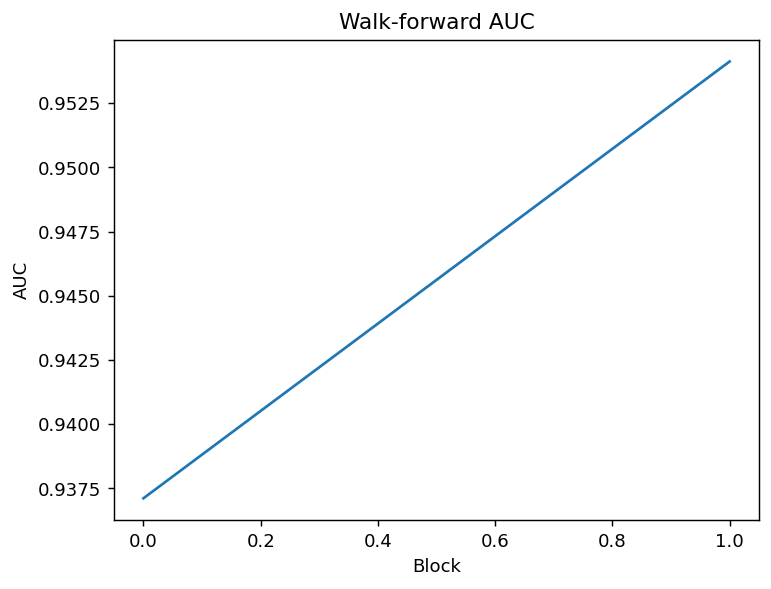

In [7]:
win = 250
aucs=[]
for start in range(0, len(X)-2*win, win):
    X_a, y_a = X.iloc[start:start+win], y.iloc[start:start+win]
    X_b, y_b = X.iloc[start+win:start+2*win], y.iloc[start+win:start+2*win]
    mdl = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    mdl.fit(X_a, y_a)
    aucs.append(roc_auc_score(y_b, mdl.predict_proba(X_b)[:,1]))
plt.plot(aucs); plt.title("Walk-forward AUC"); plt.xlabel("Block"); plt.ylabel("AUC"); plt.show()

### Challenge 2 — Leakage demo (before vs after split) + CV

In [8]:
from sklearn.model_selection import StratifiedKFold

# WRONG: scale entire X, then split
sc_all = StandardScaler().fit(X)
X_all_scaled = sc_all.transform(X)
split = int(0.8*len(X))
lr = LogisticRegression(max_iter=1000).fit(X_all_scaled[:split], y.iloc[:split])
auc_leak = roc_auc_score(y.iloc[split:], lr.predict_proba(X_all_scaled[split:])[:,1])
acc_leak = accuracy_score(y.iloc[split:], lr.predict(X_all_scaled[split:]))

# RIGHT: Pipeline
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X.iloc[:split], y.iloc[:split])
auc_clean = roc_auc_score(y.iloc[split:], pipe.predict_proba(X.iloc[split:])[:,1])
acc_clean = accuracy_score(y.iloc[split:], pipe.predict(X.iloc[split:]))

# CV sanity
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_aucs=[]
for tr, te in cv.split(X, y):
    mdl = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    mdl.fit(X.iloc[tr], y.iloc[tr])
    cv_aucs.append(roc_auc_score(y.iloc[te], mdl.predict_proba(X.iloc[te])[:,1]))

pd.DataFrame({
    "Scenario": ["Leak (scaled before split)", "Clean (Pipeline)", "Clean (CV mean AUC)"],
    "Accuracy": [acc_leak, acc_clean, np.nan],
    "AUC": [auc_leak, auc_clean, np.mean(cv_aucs)]
})

,Scenario,Accuracy,AUC
0,Leak (scaled before split),0.855,0.935994
1,Clean (Pipeline),0.855,0.935994
2,Clean (CV mean AUC),NaN,0.942760


### Challenge 3 — Baseline (Poly-LR) vs Tiny MLP (PyTorch)

In [9]:
import torch
print("PyTorch installed successfully!")
print("Version:", torch.__version__)
print("MPS (Metal) available:", torch.backends.mps.is_available())

PyTorch installed successfully!
Version: 2.8.0
MPS (Metal) available: True


In [10]:
import torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Split ADR features
X_tr, y_tr, X_va, y_va, X_te, y_te = chrono_split(X, y, 0.6, 0.2)

# Baseline: Poly-LR
poly_lr = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    LogisticRegression(max_iter=2000)
)
poly_lr.fit(X_tr, y_tr)
proba_poly = poly_lr.predict_proba(X_te)[:,1]

# Tiny MLP (logits)
scaler = StandardScaler().fit(X_tr)
Xtr = torch.tensor(scaler.transform(X_tr), dtype=torch.float32)
Xva = torch.tensor(scaler.transform(X_va), dtype=torch.float32)
Xte = torch.tensor(scaler.transform(X_te), dtype=torch.float32)
ytr = torch.tensor(y_tr.values, dtype=torch.float32).unsqueeze(1)
yva = torch.tensor(y_va.values, dtype=torch.float32).unsqueeze(1)

class TinyMLP(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, 1)  # logits
        )
    def forward(self, x): return self.net(x)

model = TinyMLP(Xtr.shape[1])
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=1e-2)
loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

best_auc, best_state, patience, wait = 0.0, None, 10, 0
for epoch in range(200):
    model.train()
    for xb, yb in loader:
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()
    model.eval()
    with torch.no_grad():
        val_proba = torch.sigmoid(model(Xva).squeeze(1)).numpy()
    val_auc = roc_auc_score(y_va, val_proba)
    if val_auc > best_auc + 1e-4:
        best_auc, best_state, wait = val_auc, model.state_dict(), 0
    else:
        wait += 1
        if wait >= patience: break

if best_state is not None:
    model.load_state_dict(best_state)

with torch.no_grad():
    test_proba = torch.sigmoid(model(Xte).squeeze(1)).numpy()

def summarize(y_true, proba, name):
    pred = (proba >= 0.5).astype(int)
    return pd.Series({
        "Accuracy": accuracy_score(y_true, pred),
        "AUC": roc_auc_score(y_true, proba),
        "F1": f1_score(y_true, pred)
    }, name=name)

pd.concat([
    summarize(y_te, proba_poly, "PolyLR(deg=3)"),
    summarize(y_te, test_proba, "TinyMLP")
], axis=1).T

,Accuracy,AUC,F1
PolyLR(deg=3),0.950,0.980098,0.948980
TinyMLP,0.965,0.985799,0.964467
